# Домашнее задание 8

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 21 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_8

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим билинейную седловую задачу:
\begin{equation}
\min_{x \in [-10; 10]^d} \max_{y \in [-10; 10]^d} f(x,y) = (x-b_x)^T A (y - b_y) + \frac{\lambda}{2}\| x - b_x\|^2 - \frac{\lambda}{2}\| y - b_y\|^2,
\end{equation}
где в качестве матрицы $A$ - случайно сгенерированная матрица с $L =1000$, $\mu = 0.01$, $d = 100$, $b_x$ и $b_y$ - случайные векторы c компонентами из отрезка $[-10; 10]$, $\lambda = 1$.

__(а)__ Какое решение у данной задачи? Является ли данная задача сильно выпуклой по $x$ и сильно вогнутой по $y$? Если да, то чему равна константа сильной выпуклости? Является ли оператор, соотвествующего это задаче вариационного неравенства, сильно монотонным? Липшицевым? Чему равны $L$ и $\mu$ для данного оператора? 

Да, он является сильно монотонным.

Эта функция $\lambda$ сильно выпукла по $x$, $\lambda$ сильно вогнута по $y$.

Оператор, соответствующий этой задаче, имеет $\mu = 2$ (берется от норм) и $L = 1000$ (от квадратичной части, нормы в константу Липшица вносят малый вклад).

Вывод прикреплю.

In [2]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

In [140]:
def generate(d = 100, m = 1, L = 1000, border=10):

    # сгенерируем диагональную матрицу по собственным числам
    if d == 1:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]

    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    b_x = np.random.uniform(low=-border, high=border, size=(d,))
    b_y = np.random.uniform(low=-border, high=border, size=(d,))

    return A, b_x, b_y

In [141]:
L = 1000
m = 0.01
d = 100

A, b_x, b_y = generate(d=d, m=m, L=L)
z0 = np.random.uniform(low=-10, high=10, size=(2*d,))
mu = 2

__(б)__ Решите данную задачу с помощью метода градиентного спуска(подъема) с проекцией и с помощью метода Экстраградиента с проекцией(смотри Секцию 3.3 [статью](https://arxiv.org/pdf/1802.10551.pdf)). Для начала попробуйте теоретические шаги для данных методов. Далее подберите шаг для наилучшей сходимости. Постройте график сходимости (относительное расстояние до решения по аргументу от числа подсчетов градиентов). На графике должно быть 4 линии, по две на каждый из методов. Сделайте вывод.

In [3]:
def split(z):
    return np.split(z, 2)[0], np.split(z, 2)[1]

def merge(x, y):
    return np.concatenate((x, y), axis=None)

In [142]:
def F(z):
    l = len(z)
    x, y = split(z)
    grad_x = A @ (y - b_y) + (x - b_x)
    grad_y = A.T @ (x - b_x) - (y - b_y)
    return merge(grad_x, -grad_y)

In [11]:
def err_norm(z):
    return np.linalg.norm(F(z), ord=2)**2

def err_R(z):
    x, y = split(z)
    return np.linalg.norm(x - b_x, ord=2)**2 + np.linalg.norm(y - b_y, ord=2)**2

In [144]:
def proj(x):
    for i in range(len(x)):
        if x[i] > 10:
            x[i] = 10
        elif x[i] < -10:
            x[i] = -10
    return x

def GD(z0, gamma, error, iters=3000):
    z = z0
    z_vals = [z]
    grads_cnt = 0
    grads = [0]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        z = proj(z - gamma * F(z))

        z_vals.append(z)
        grads_cnt += 2
        grads.append(grads_cnt)
        times.append(time.time() - start)
        errs.append(error(z))

    return z_vals, grads, times, errs

def ExtraGD(z0, gamma, error, iters=3000):

    z = z0
    z_vals = [z]
    grads_cnt = 0
    grads = [0]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        w = proj(z - gamma * F(z))
        z = proj(z - gamma * F(w))

        z_vals.append(z)
        grads_cnt += 4
        grads.append(grads_cnt)
        times.append(time.time() - start)
        errs.append(error(z))

    return z_vals, grads, times, errs

In [4]:
def risovach(grads, errs, labels, title='', log=True):

    plt.figure(figsize=(9, 6))
    if log:
        for gr, err, lab in zip(grads, errs, labels):
            plt.plot(gr, np.log(err), label=lab)
        ylabel = 'Логарифм критерия'
    else:
        for gr, err, lab in zip(grads, errs, labels):
            plt.plot(gr, err, label=lab)
        ylabel = 'Значение критерия'

    plt.xlabel("Число вызовов градиента")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(fontsize=12)
    plt.show()

In [146]:
iters = 2000

z_extra, grads_extra, times_extra, errs_extra = ExtraGD(z0, gamma=1/(3*L), error=err_R, iters=iters)
z_extrab, grads_extrab, times_extrab, errs_extrab = ExtraGD(z0, gamma=1/L, error=err_R, iters=iters)
z_gd, grads_gd, times_gd, errs_gd = GD(z0, gamma=mu/(L*L), error=err_R, iters=2*iters)
z_gdb, grads_gdb, times_gdb, errs_gdb = GD(z0, gamma=30/(L*L), error=err_R, iters=2*iters)

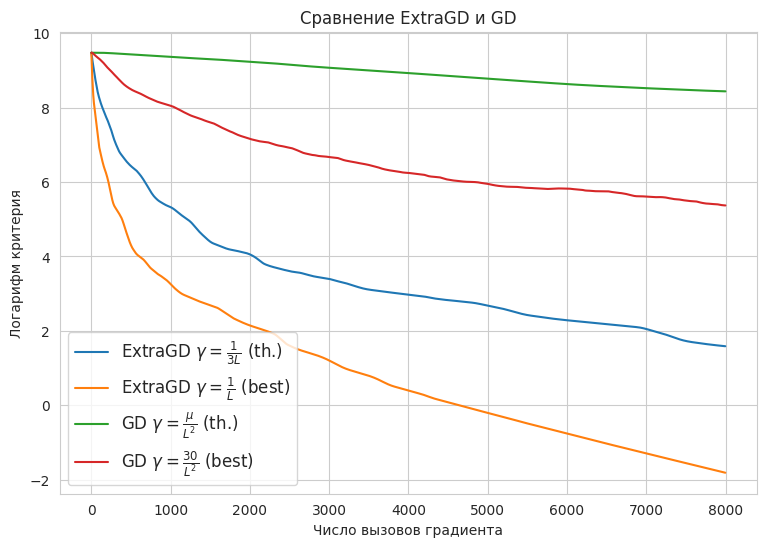

In [147]:
risovach(grads=[grads_extra, grads_extrab, grads_gd, grads_gdb], 
         errs=[errs_extra, errs_extrab, errs_gd, errs_gdb], 
         labels=[r'ExtraGD $\gamma = \frac{1}{3L}$ (th.)', r'ExtraGD $\gamma = \frac{1}{L}$ (best)',
                 r'GD $\gamma = \frac{\mu}{L^2}$ (th.)', r'GD $\gamma = \frac{30}{L^2}$ (best)'],
         title='Сравнение ExtraGD и GD')

Видим, что в градиентном спуске с проекцией можно значительно отойти от теоретической оценки размера шага, улучшив сходимость.

Extragradient descent оказался существенно быстрее даже с учетом того, что его итерация вдвое дороже.

## Задача 2

Теперь рассмотрим билинейную задачу на симплексе. Описание задачи возьмите из [лекций](https://www2.isye.gatech.edu/~nemirovs/BrazilTransparenciesJuly4.pdf) - Слайд 125 "How it Works: Policeman vs. Burglar" и следующий.

__(а)__ Сгенерируйте матрицу для данной задачи размера $n=10$ c $\theta = 1$.

In [87]:
n = 10
d = 10*10

# стоимости
B = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        B[i][j] = min(i,j,9-i,9-j) + random.random()

# игровая матрица
A = np.zeros((n*n, n*n))
for i in range(n*n):
    for j in range(n*n):
        dist = abs(i//n - j//n) + abs(i%n - j%n)
        A[i][j] = B[i//n][i%n] * (1 - np.exp(-dist))

In [110]:
L = round(np.max(np.real(np.linalg.eigvals(A))))
mu = round(np.min(np.real(np.linalg.eigvals(A))))
print(L, mu)

156 -9


__(б)__ Для данной задачи предложите модификацию метода Экстраградиента, которая учитывает, что задача решается на симплексе. В этом может помочь [статья](https://arxiv.org/pdf/0809.0815.pdf) (смотри Секцию 3.3). Реализуйте данный метод.

$$f(x,y) = y^TAx \Rightarrow F(z) = \begin{pmatrix}
\nabla_xf(x,y)\\
-\nabla_yf(x,y)
\end{pmatrix} = \begin{pmatrix}
y^TA\\
-Ax
\end{pmatrix}$$

Критерий будем использовать двойственный:
$$\text{gap}(k) = \text{gap}(x^k, y^k) = \underset{y\in Z}{\max} f(x^k, y) - \underset{x\in Z}{\min} f(x,y^k)$$

In [101]:
def dfx(y):
    return y.T @ A

def dfy(x):
    return - A @ x

def gap(x, y):
    sum = 0
    Ax = A @ x
    yA = y.T @ A
    for i in range(d):
        for j in range(d):
            if (Ax[i] - yA[j] > sum):
                sum = Ax[i] - yA[j]
    return sum

def pr(r, x):
    q = np.zeros(d)
    temp = 0.
    for i in range(d):
        temp += r[i] * np.exp(-x[i])
    temp = 1/temp
    for i in range(d):
        q[i] = temp * (r[i]*np.exp(-x[i]))
    return q

def NewExtraGD(gamma=1, iters=1000):
    
    times = []
    start = time.time()
    errs = []

    rx = np.ones(d) / d
    ry = rx
    wx = np.zeros(d)
    wy = wx
    
    for i in range(0, iters):

        wx = pr(rx, gamma*dfx(ry))
        wy = pr(ry, gamma*dfy(rx))
        rx = pr(rx, gamma*dfx(wy))
        ry = pr(ry, gamma*dfy(wx))

        times.append(time.time() - start)
        errs.append(gap(rx, ry))

    grads = [4*i for i in range(len(errs))]

    return grads, times, errs, rx, ry

In [89]:
def proj_(x):
    u = np.sort(x)
    u = u[::-1]
    r = 0
    s = 0
    for i in range(len(u)):
        s += u[i]
        r = i + 1
        if ((u[i] + ((1 - s) / r)) <= 0):
            s -= u[i]
            r -= 1
            break
    l = (1 - s) / r
    y = []
    for i in x:
        y.append(max(i + l, 0))
    return np.array(y)

def ExtraGD_(gamma=1e-2, iters=1000):

    x0 = np.random.uniform(low=0, high=1, size=(d,)) / d
    y0 = np.random.uniform(low=0, high=1, size=(d,)) / d
    x, y = x0, y0
    tx, ty = dfx(y0), dfy(x0)
    
    times = [0.]
    start = time.time()
    errs = [0.]

    for i in range(1, iters):

        x0 = proj_(x - gamma * tx)
        y0 = proj_(y - gamma * ty)
        tx = dfx(y0)
        ty = dfy(x0)
        x = proj_(x - gamma * tx)
        y = proj_(y - gamma * ty)
        tx = dfx(y)
        ty = dfy(x)

        times.append(time.time() - start)
        errs.append(gap(x, y))

    grads = [4*i for i in range(len(errs))]

    return grads, times, errs

def GD_(gamma=1e-2, iters=1000):

    x = np.random.uniform(low=0, high=1, size=(d,)) / d
    y = np.random.uniform(low=0, high=1, size=(d,)) / d

    times = [0.]
    start = time.time()
    errs = [0.]

    for i in range(1, iters):

        gx = dfx(y)
        gy = dfy(x)
        x = proj_(x - gamma * gx)
        y = proj_(y - gamma * gy)

        times.append(time.time() - start)
        errs.append(gap(x, y))

    grads = [2*i for i in range(len(errs))]

    return grads, times, errs

__(в)__ Решите билинейную задачу на симплексе с помощью нового метода и методов из Задачи 1. Как будете измерять сходимость? Возможно, в работах, из которых были взяты методы, найдется ответ. Постройте график сходимости. Визуализирйте полученный ответ, как это сделано в файле с лекциями. Сделайте вывод.  

In [102]:
iters = 2000

grads_new, times_new, errs_new, x, y = NewExtraGD(gamma=1, iters=iters)
grads_extra, times_extra, errs_extra = ExtraGD_(gamma=10/L, iters=iters)
grads_gd, times_gd, errs_gd = GD_(gamma=30/(L*L), iters=2*iters)

/tmp/ipykernel_3069/1081507540.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(gr, np.log(err), label=lab)


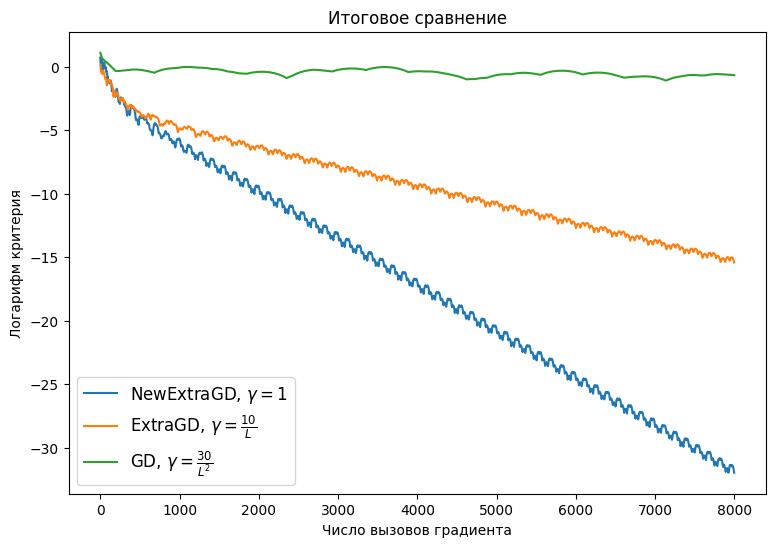

In [103]:
risovach(grads=[grads_new, grads_extra, grads_gd], 
         errs=[errs_new, errs_extra, errs_gd], 
         labels=[r'NewExtraGD, $\gamma = 1$', r'ExtraGD, $\gamma = \frac{10}{L}$', r'GD, $\gamma = \frac{30}{L^2}$'],
         title='Итоговое сравнение')

1. На не сильно выпуклой задаче GD не показал толком никакой сходимости.

2. ExtraGD все еще линейно сходится.

3. Чемпион - модифицированный экстраградиент из задачи 2.б

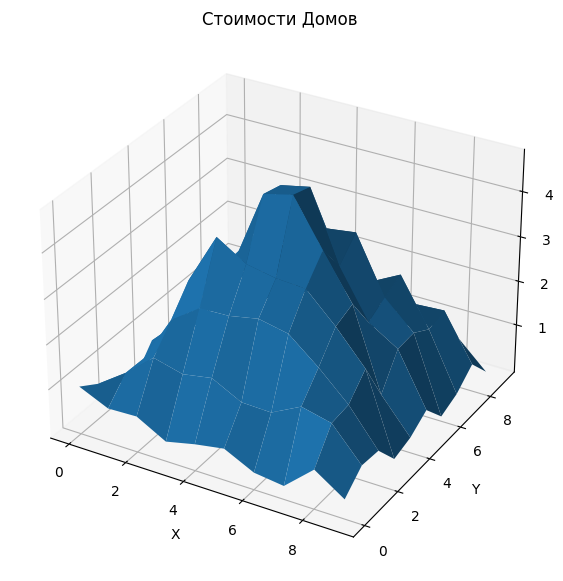

In [111]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(range(10), range(10))
Z = np.copy(B)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Стоимости Домов')

plt.show()

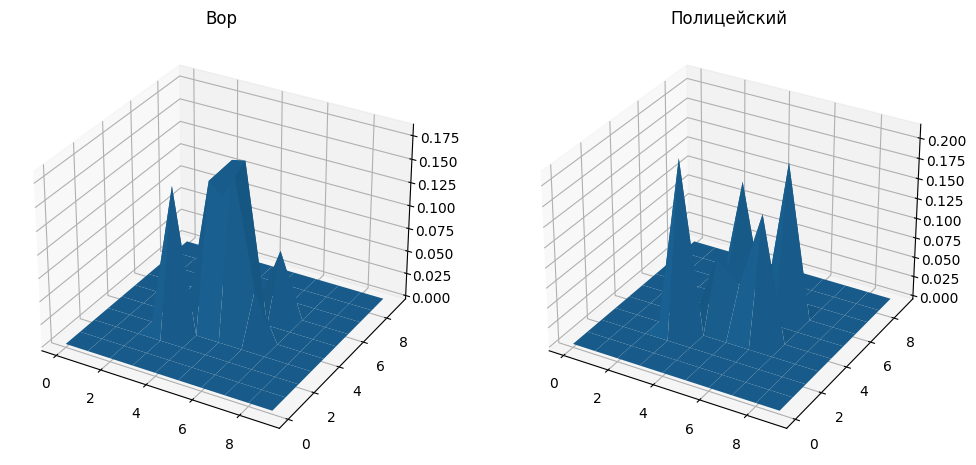

In [119]:
fig = plt.figure(figsize=(12, 8))

X, Y  = np.meshgrid(range(10), range(10))
Z1 = np.zeros((n, n))
Z2 = np.zeros((n, n))
for i in range(10):
    for j in range(10):
        Z1[i][j] = x[i*n + j]
        Z2[i][j] = y[i*n + j]

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z1)
ax.set_title('Вор')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z2)
ax.set_title('Полицейский')

plt.show()

Графики для вора и полицейского выглядят очень похоже, поскольку у нашей задачи оптимум $x^* = y^* = 0$. Пики в центре, поскольку там наибольшая стоимость домов. И им обоим туда хочется.

__Бонусные пункты__

__(г)__ Реализуйте методы из Секции 3 [работы](https://arxiv.org/pdf/1908.08465.pdf). Решите с помощью них Задачу 1. Добавьте сходимость на график из пункта (б) Задачи 1.

In [ ]:
#ответ

__(д)__ Реализуйте Алгоритм 1 и Алгоритм 2 из [работы](https://arxiv.org/pdf/2102.08352.pdf). Решите с помощью них Задачу 2 (могут помочь Секции 5 и 6 из упомянутой работы). Добавьте сходимость на график из пункта (в) Задачи 2, предварительно поменяв ось $x$ (что теперь будете откладывать по оси $x$?).

In [ ]:
#ответ